## Linear Regression and Other Things: Cross-sectional, Panel, DiD and RDD

- Admin:
    - Presentations: Okay not to be done yet
    - Office Hours on Wednesday will be 10:30-11:30 (shifted by 30 minutes)
    - Class on Thursday will be over ZOOM
- What we're doing today
    - How do you run regressions in Python?
        - Specifically, CAUSAL regressions
        - For ML - NICE
        - For Data Processing - NICE
        - For Data Visualization - NICE
        - For causal methods -  meh
    - But recently, things have been getting ALOT better
    - libraries used: `statsmodels`, `scipy`, `linearmodels`, `rdrobust`, and `differences`
    - For bootstrapped clustered standard errors, there `wildboottest`
- This isn't meant to be an econometrics course, just a primer on what you can do.
- Before we go on though, we need to talk about formulas


## Formulas

- When estimating linear models, we need an X and y:

$$
y_i = X_i\beta + \varepsilon_i
$$

And for many programs, thats what you need, an `endog` and `exog`, or $y$ and $X$.

But in many instances, you might want to do something more readable, and perhaps you might want to even estimate transformations of variables, or interactions

That's why it's more intuitive and recommended to use R-style formulas in your models.

Most of the libraries we use will use these types of formulas.


## Getting Started

- First:

```
pip install statsmodels
pip install linearmodels
pip install differences
pip install rdrobust
pip install wildboottest
```

- There of course other packages you can use that implement these things. But these are packages that I have used and think work well
- Note: `differences` is a package for "multi-valued and staggered treatment" for differences in differences. You can implement simple differences in differences yourself pretty easily.
- `rdrobust` is a well-known package that started in R and Stata and has been ported to Python by the authors

## Formulas

- There are two main libraries that other packages use for formulas
    - `patsy` - older but still used by statsmodels 
    - `formulaic` newer and more maintained
    - These are mostly the same for most use-cases, but have some small differences.
- Let's just look at making formulas
    - We'll use `formulaic` (it's already installed as part of `linearmodels`)
    - Note: you don't have to import it separately, `linearmodels` just uses it

In [2]:
from formulaic import Formula
from differences import ATTgt, TWFE, simulate_data
from rdrobust import rdrobust, rdplot
from linearmodels import PooledOLS, PanelOLS, IV2SLS
import statsmodels.formula.api as smf
from wildboottest.wildboottest import wildboottest
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [2]:
# Let's create some data that we'll use for the rest of the lecture.

# households and time periods
hhids = list(range(1,101))
time_periods = list(range(0,10))
N = len(hhids)
T = len(time_periods)

# choose treated households
rng = np.random.default_rng(seed=1234)

treated = rng.choice(hhids, int(N/2))

# Create fixed effects
alpha_i = {k:v for k,v in zip(hhids, rng.normal(3,2, size=N))}
alpha_t = {k:v for k,v in zip(time_periods, rng.normal(2,1, size=T))}

# create multi-index
multiindex = pd.MultiIndex.from_product([hhids, time_periods], names = ['hhid', 'time'])

# time of treatment
t_star = 5

# effect of controls
gamma = .3

# create variables
df = (
    pd.DataFrame(index = multiindex,
                  columns = ['y'], 
                  data=np.where(multiindex.get_level_values('hhid').isin(treated), 10, 1)
                  )
    .assign(y = lambda df: np.where((df.index.get_level_values('time') >= t_star) \
        & (df.index.get_level_values('hhid').isin(treated)), 
        df['y'] + 10, 
        df['y']),
            treat = lambda df: df.index.get_level_values('hhid').isin(treated).astype(int),
            time_of_treat = lambda df: np.where(df.index.get_level_values('time')>=t_star, 1, 0),
            X = lambda df: rng.normal(100,30, size=N*T),
            alpha_i = lambda df: df.index.get_level_values('hhid').map(alpha_i),
            alpha_t = lambda df: df.index.get_level_values('time').map(alpha_t),
            error_it = rng.normal(0,1, size=N*T))
    .assign(y_did = lambda df: df['y'] + df['X']*gamma + df['alpha_i'] + df['alpha_t'] + df['error_it'],
            y_ols = lambda df: 1 + df['X']*gamma + df['error_it'],
            y_twfe = lambda df: df['X']*gamma + df['alpha_i'] + df['alpha_t'] + df['error_it'],

    )
)

df

y  treat  time_of_treat           X   alpha_i   alpha_t  error_it  \
hhid time                                                                      
1    0     1      0              0   57.096283  0.685178  2.158266  0.082832   
     1     1      0              0   62.379261  0.685178  0.909438  0.190193   
     2     1      0              0  112.179927  0.685178  0.680284 -0.308207   
     3     1      0              0   92.853249  0.685178  2.838651  0.107088   
     4     1      0              0  123.493952  0.685178  4.119764 -0.356980   
...       ..    ...            ...         ...       ...       ...       ...   
100  5     1      0              1   60.216512  3.875725  1.950428 -0.199474   
     6     1      0              1   81.279531  3.875725  2.325698 -0.150037   
     7     1      0              1   89.517010  3.875725  1.451677 -0.516810   
     8     1      0              1   77.633048  3.875725  1.729681  0.389811   
     9     1      0              1  101.491605  3.875725  0.327195  0.012241   

               y_did      y_ols     y_twfe  
hhid time                                   
1    0     21.055161  18.211717  20.055161  
     1     21.498588  19.903971  20.498588  
     2     35.711233  34.345771  34.711233  
     3     32.486893  28.963063  31.486893  
     4     42.496148  37.691206  41.496148  
...              ...        ...        ...  
100  5     24.691632  18.865479  23.691632  
     6     31.435244  25.233822  30.435244  
     7     32.665694  27.338293  31.665694  
     8     30.285131  24.679725  29.285131  
     9     35.662642  31.459722  34.662642  

[1000 rows x 10 columns]

<Axes: xlabel='time', ylabel='y_did'>

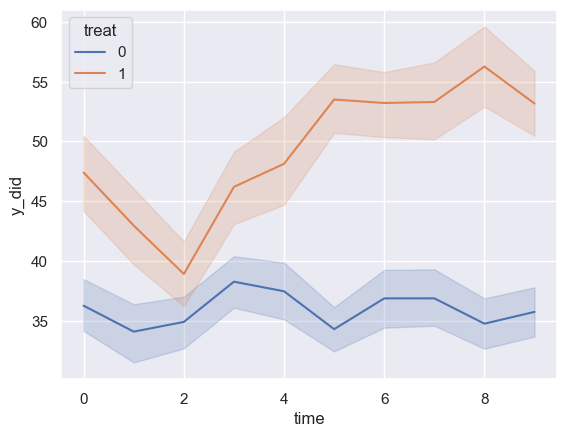

In [6]:
sns.lineplot(x='time', y='y_did', data=df, hue='treat')

In [ ]:
"y ~ X + X_controls + W"

In [7]:
f = Formula("y_ols ~ X").get_model_matrix(df)

In [8]:
f.lhs

y_ols
hhid time           
1    0     18.211717
     1     19.903971
     2     34.345771
     3     28.963063
     4     37.691206
...              ...
100  5     18.865479
     6     25.233822
     7     27.338293
     8     24.679725
     9     31.459722

[1000 rows x 1 columns]

In [9]:
f.rhs

Intercept           X
hhid time                       
1    0           1.0   57.096283
     1           1.0   62.379261
     2           1.0  112.179927
     3           1.0   92.853249
     4           1.0  123.493952
...              ...         ...
100  5           1.0   60.216512
     6           1.0   81.279531
     7           1.0   89.517010
     8           1.0   77.633048
     9           1.0  101.491605

[1000 rows x 2 columns]

-  Intercept is automatically included!
- But you can do even more with this
    - Create polynomials
    - apply transformations (using numpy functions)
    - Create dummy variables
    - Create interactions
    - get rid of the intercept

In [10]:

Formula("y_ols ~ -1 + C(treat, Treatment(1)) + np.log(X) + treat*X").get_model_matrix(df).rhs

C(treat)[T.0]  C(treat)[T.1]           X  np.log(X)  treat  X:treat
hhid time                                                                     
1    0                 1              0   57.096283   4.044739      0      0.0
     1                 1              0   62.379261   4.133233      0      0.0
     2                 1              0  112.179927   4.720104      0      0.0
     3                 1              0   92.853249   4.531020      0      0.0
     4                 1              0  123.493952   4.816192      0      0.0
...                  ...            ...         ...        ...    ...      ...
100  5                 1              0   60.216512   4.097947      0      0.0
     6                 1              0   81.279531   4.397894      0      0.0
     7                 1              0   89.517010   4.494429      0      0.0
     8                 1              0   77.633048   4.351993      0      0.0
     9                 1              0  101.491605   4.619976      0      0.0

[1000 rows x 6 columns]

-  notice when I use the `*` operator, it isn't a multiplication.
- It's actually interaction that adds `treat`, `X` and `treat:X`
    - To just add the interaction, put in `treat:X`


## OLS 

- For regular-degular OLS, we estimate $\beta$ in the equation:

$$
y_i = X_i\beta + \varepsilon_{i}
$$

- To run a regression like this, we use `statsmodels`

In [11]:
mod = smf.ols("y_ols ~ X", data=df)

/Users/lordflaron/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/lordflaron/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/lordflaron/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


- That creates a model object

In [16]:
mod.formula

'y_ols ~ X'

In [18]:
# To estimate the model, call `fit`

res_ols = mod.fit()

In [19]:
res_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  y_ols   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 8.374e+04
Date:                Tue, 24 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:11:40   Log-Likelihood:                -1409.3
No. Observations:                1000   AIC:                             2823.
Df Residuals:                     998   BIC:                             2832.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9946      0.107      9.302      0.000       0.785       1.204
X              0.3005      0.001    289.382      0.000       0.298       0.303
==============================================================================
Omnibus:                        8.949   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.989
Skew:                           0.207   Prob(JB):                       0.0112
Kurtosis:                       3.212   Cond. No.                         351.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- This assumes homoskedastic errors, but we can make things a bit more robust using `cov_type`

In [20]:
mod.fit(cov_type='HC1').summary()
# HC1 denotes White-Robust Standard Errors, the same , robust in Stata

# Of course, our error is homoskedastic so it doesn't do much

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  y_ols   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 9.104e+04
Date:                Tue, 24 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:12:40   Log-Likelihood:                -1409.3
No. Observations:                1000   AIC:                             2823.
Df Residuals:                     998   BIC:                             2832.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9946      0.103      9.633      0.000       0.792       1.197
X              0.3005      0.001    301.728      0.000       0.299       0.302
==============================================================================
Omnibus:                        8.949   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.989
Skew:                           0.207   Prob(JB):                       0.0112
Kurtosis:                       3.212   Cond. No.                         351.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### Instrumental Variables

- To do instrumental variables, use `IV2SLS` from `linearmodels`
- The formula is a little different but intuitive

In [11]:
mod = IV2SLS.from_formula("y ~ [treat ~ X]", data=df)

mod.fit().summary ### notice that it's an attribute, not a method

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      y   R-squared:                      0.8816
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8815
No. Observations:                1000   F-statistic:                    3052.9
Date:                Thu, Oct 19 2023   P-value (F-stat)                0.0000
Time:                        23:09:59   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
treat          16.743     0.3030     55.253     0.0000      16.149      17.337
==============================================================================

Endogenous: treat
Instruments: X
Robust Covariance (Heteroskedastic)
Debiased: False
"""

## Panel Regression

- In this section, now we assume that there is hierarchy in the data
- There might be households that are repeatedly measured at multiple time periods
- In this case, we estimate:

$$
y_{it} = X_{it} \beta + \alpha_i + \alpha_t + \varepsilon_{it}
$$

- So there may now be errors that are individual/unit/household specific and also time-specific.
- To tackle this kind of question, we use `linearmodels`

### Fixed Effects

-  We could of course run this using the regular OLS model
    - Which we actually did
        - But that would give us a Pooled Estimate, which is not efficient
        - But in order to run fixed effects (or Random Effects)
        - we use `PanelOLS` from `linearmodels`
        - And we have to specify the index of the two levels
            - but in this case we already have that, `hhid` and `time`

In [23]:
df#.set_index(['hhid', 'time'])

y  treat  time_of_treat           X   alpha_i   alpha_t  error_it  \
hhid time                                                                      
1    0     1      0              0   57.096283  0.685178  2.158266  0.082832   
     1     1      0              0   62.379261  0.685178  0.909438  0.190193   
     2     1      0              0  112.179927  0.685178  0.680284 -0.308207   
     3     1      0              0   92.853249  0.685178  2.838651  0.107088   
     4     1      0              0  123.493952  0.685178  4.119764 -0.356980   
...       ..    ...            ...         ...       ...       ...       ...   
100  5     1      0              1   60.216512  3.875725  1.950428 -0.199474   
     6     1      0              1   81.279531  3.875725  2.325698 -0.150037   
     7     1      0              1   89.517010  3.875725  1.451677 -0.516810   
     8     1      0              1   77.633048  3.875725  1.729681  0.389811   
     9     1      0              1  101.491605  3.875725  0.327195  0.012241   

               y_did      y_ols     y_twfe  
hhid time                                   
1    0     21.055161  18.211717  20.055161  
     1     21.498588  19.903971  20.498588  
     2     35.711233  34.345771  34.711233  
     3     32.486893  28.963063  31.486893  
     4     42.496148  37.691206  41.496148  
...              ...        ...        ...  
100  5     24.691632  18.865479  23.691632  
     6     31.435244  25.233822  30.435244  
     7     32.665694  27.338293  31.665694  
     8     30.285131  24.679725  29.285131  
     9     35.662642  31.459722  34.662642  

[1000 rows x 10 columns]

In [25]:
mod_twfe = PanelOLS.from_formula("y_twfe ~ 1 + X", data=df)

res_twfe = mod_twfe.fit()

res_twfe.summary ## Notice that this is an attribute not a method

Dep. Variable:,y_twfe,R-squared:,0.9236
Estimator:,PanelOLS,R-squared (Between):,0.6115
No. Observations:,1000,R-squared (Within):,0.9734
Date:,"Tue, Oct 24 2023",R-squared (Overall):,0.9236
Time:,12:17:17,Log-likelihood,-2379.3
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1.206e+04
Entities:,100,P-value,0.0000
Avg Obs:,10.0000,Distribution:,"F(1,998)"
Min Obs:,10.0000,,
Max Obs:,10.0000,F-statistic (robust):,1.206e+04


- You can already see that the standard errors are different
- But how do we specify fixed effects?

In [26]:
mod_twfe = PanelOLS.from_formula("y_twfe ~ X ", data=df)


In [36]:
mod_twfe = PanelOLS.from_formula("y_twfe ~ X + gender + EntityEffects + TimeEffects", data=df) #+EntityEffects + TimeEffects
res_twfe = mod_twfe.fit()

In [38]:
res_twfe.summary # and we recover the original coefficient

Dep. Variable:,y_twfe,R-squared:,0.9880
Estimator:,PanelOLS,R-squared (Between):,0.9741
No. Observations:,1000,R-squared (Within):,0.9734
Date:,"Tue, Oct 24 2023",R-squared (Overall):,0.9740
Time:,12:20:05,Log-likelihood,-1365.5
Cov. Estimator:,Unadjusted,,
,,F-statistic:,7.303e+04
Entities:,100,P-value,0.0000
Avg Obs:,10.0000,Distribution:,"F(1,890)"
Min Obs:,10.0000,,
Max Obs:,10.0000,F-statistic (robust):,7.303e+04


## Differences-in-Differences

- Difference-in-Differences is a popular way to get a causal effect
- It depends on the assumption of parallel trends:
    - If the treated and untreated groups "evolved" similarly before the onset of treatment (here assumed to happen once and at the same for all treated groups), then you can recover the treatment effect.


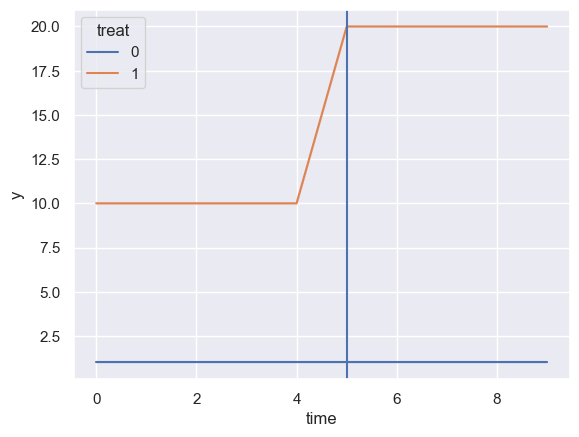

In [16]:
fig, ax  = plt.subplots()

sns.lineplot(x='time', y= 'y', hue='treat', data=df, ax=ax)
ax.axvline(t_star)

- In practice it looks something more like this (if you're lucky)

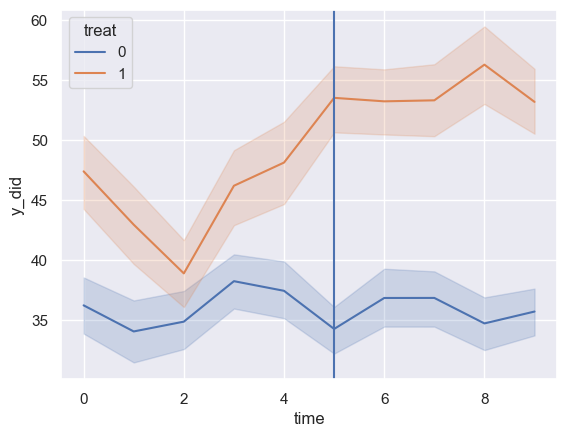

In [39]:
fig, ax  = plt.subplots()

sns.lineplot(x='time', y= 'y_did', hue='treat', data=df, ax=ax)
ax.axvline(t_star)

### Basic 2x2 DiD

- What should the treatment effect be?
- Above, we defined, the variables as:

```
y_1_post = 20
y_1_pre = 10
y_0_post = 1
y_0_pre = 1

(y_1_post - y_0_post) - (y_1_pre - y_0_pre) = (20-1) - (10-1) = 19 - 9 = 10
```


- In a basic setup like this (and let's just assume that parallel trends are a-okay), you can calculate the treatment effect using `PanelOLS` and by looking at just one two time periods, before and after:

$$
y = treat_i\beta_1 + timeAfter_t\beta_2 + treat_i\cdot timeAfter_t \beta_3 + X\gamma +  \varepsilon_{it}
$$

In [50]:
# first we need to take out all time before and after

PanelOLS.from_formula("y_did ~ treat*time_of_treat + X +EntityEffects + TimeEffects", data = df.query("4 <= time <= 6"), drop_absorbed=True).fit().summary


/var/folders/22/d2d1hrtn3kl9cq0gsx95c6lr0000gn/T/ipykernel_94662/1256471822.py:3: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

time_of_treat, treat



Dep. Variable:,y_did,R-squared:,0.9887
Estimator:,PanelOLS,R-squared (Between):,0.9325
No. Observations:,300,R-squared (Within):,0.9704
Date:,"Tue, Oct 24 2023",R-squared (Overall):,0.9337
Time:,12:46:40,Log-likelihood,-364.81
Cov. Estimator:,Unadjusted,,
,,F-statistic:,8593.7
Entities:,100,P-value,0.0000
Avg Obs:,3.0000,Distribution:,"F(2,196)"
Min Obs:,3.0000,,
Max Obs:,3.0000,F-statistic (robust):,8593.7


In [20]:
res_did = PanelOLS.from_formula("y ~ treat:time_of_treat + X + EntityEffects + TimeEffects", data = df).fit()

res_did.summary


Dep. Variable:,y,R-squared:,1.0000
Estimator:,PanelOLS,R-squared (Between):,0.5512
No. Observations:,1000,R-squared (Within):,1.0000
Date:,"Thu, Oct 19 2023",R-squared (Overall):,0.5958
Time:,23:10:33,Log-likelihood,3.246e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,6.847e+32
Entities:,100,P-value,0.0000
Avg Obs:,10.0000,Distribution:,"F(2,889)"
Min Obs:,10.0000,,
Max Obs:,10.0000,F-statistic (robust):,6.847e+32


### Callaway-Sant'Anna DiD

- But what if you were in a situation where there were multiple units receiving treatment and they were receiving at different times?
- What if there's a staggered roll-out of a program?
- In this case we use `difference`
- The issue that CS pointed out (after Bacon also pointed it out), was that running DiD in this setting was not reliable and it wasn't clear who your control and treatment units were
- Let's use `difference` to showcase this

WARNING: This will all look very cool, but it's dangerous stuff. Before you embark on this DiD journey, read the CS and Bacon papers

1. Difference-in-Differences with multiple time periods

https://www.sciencedirect.com/science/article/pii/S0304407620303948?casa_token=8l7qkySswJwAAAAA:pIf0ub0xOb9cDp5brNBwJP6oc5I7vo9jGyc0WFiEIIoo3CbcCvo-FxPmr4IX43NBchc8-BOBASI


2. Difference-in-differences with variation in treatment timing

https://www.sciencedirect.com/science/article/pii/S0304407621001445?casa_token=Y7tyX8uTh4sAAAAA:Foh_ScSborm4O_f4i8l8qBxC_EAHad6kZdufCVYthHT0TJeltMq_IoivG-fq94E2bJ7hML-9L20


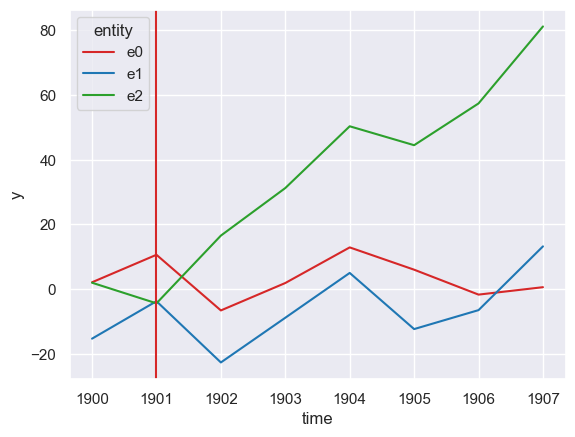

In [62]:
df_did = simulate_data(n_cohorts=1, nentity=2)

fig, ax = plt.subplots()

sns.lineplot(x='time', y = 'y', hue='entity', data=simulate_data(n_cohorts=2, nentity=3), ax=ax, palette=["tab:red", "tab:blue", "tab:green"])

for i,c in zip(df_did.cohort.unique(), ["tab:red", "tab:blue", "tab:green"]):
    ax.axvline(i, color=c)

In [55]:
res_att = ATTgt(data=df_did, cohort_name='cohort')

res_att.fit(formula='y')

/Users/lordflaron/opt/anaconda3/lib/python3.9/site-packages/differences/tools/panel_validation.py:138: FutureWarning: The provided callable <function amin at 0x7fd13876df70> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
/Users/lordflaron/opt/anaconda3/lib/python3.9/site-packages/differences/tools/panel_validation.py:138: FutureWarning: The provided callable <function amax at 0x7fd13876ddc0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
Computing ATTgt [workers=1]   100%|████████████████████| 14/14 [00:00<00:00, 191.57it/s]


ATTgtResult                                            \
                                     analytic pointwise conf. band              
                                ATT std_error                lower      upper   
cohort base_period time                                                         
1903   1900        1901   24.238239       NaN            24.238239  24.238239   
       1901        1902  -23.005113       NaN           -23.005113 -23.005113   
       1902        1903   18.504658       NaN            18.504658  18.504658   
                   1904   37.732927       NaN            37.732927  37.732927   
                   1905   24.269083       NaN            24.269083  24.269083   
                   1906   -8.360279       NaN            -8.360279  -8.360279   
                   1907   -3.508013       NaN            -3.508013  -3.508013   
1907   1900        1901   22.693139       NaN            22.693139  22.693139   
       1901        1902    9.967471       NaN             9.967471   9.967471   
       1902        1903   16.871902       NaN            16.871902  16.871902   
       1903        1904  -21.423220       NaN           -21.423220 -21.423220   
       1904        1905  -11.795849       NaN           -11.795849 -11.795849   
       1905        1906   -6.329448       NaN            -6.329448  -6.329448   
       1906        1907  -11.477322       NaN           -11.477322 -11.477322   

                                           
                                           
                        zero_not_in_cband  
cohort base_period time                    
1903   1900        1901                 *  
       1901        1902                 *  
       1902        1903                 *  
                   1904                 *  
                   1905                 *  
                   1906                 *  
                   1907                 *  
1907   1900        1901                 *  
       1901        1902                 *  
       1902        1903                 *  
       1903        1904                 *  
       1904        1905                 *  
       1905        1906                 *  
       1906        1907                 *

In [56]:
res_att.aggregate('time')
res_att.plot('time')

/Users/lordflaron/opt/anaconda3/lib/python3.9/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
/Users/lordflaron/opt/anaconda3/lib/python3.9/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.HConcatChart(...)

In [57]:
res_att.aggregate('event')
res_att.plot('event')

/Users/lordflaron/opt/anaconda3/lib/python3.9/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
/Users/lordflaron/opt/anaconda3/lib/python3.9/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.HConcatChart(...)

In [58]:
res_att.aggregate('cohort')
res_att.plot('cohort', lines=False)

/Users/lordflaron/opt/anaconda3/lib/python3.9/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
/Users/lordflaron/opt/anaconda3/lib/python3.9/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
/Users/lordflaron/opt/anaconda3/lib/python3.9/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.HConcatChart(...)

In [59]:
res_att.aggregate('simple')


SimpleAggregation                                            \
                     analytic pointwise conf. band              
                ATT std_error                lower      upper   
0          9.526842  4.950729            -0.176408  19.230093   

                     
                     
  zero_not_in_cband  
0

### Event Studies

- `differences` also allows you to estimate event studies, again assuming that there may be different points at which treatment happens and at different intensities of treatment
- Event studies are usually implemented with twoway-fixed effects, unit fixed effects, and time period fixed effects
    - But this is problematic because with the "event," it isn't clear who the comparison group is to the treated.
- With CS, there comes ways of getting around this:

In [104]:
import differences; differences.__version__

'0.1.2'

In [107]:
data = simulate_data()

TWFE(data=data, cohort_name='cohort').fit(formula='y', cluster_names='entity')

# Nevermind, there's bug in the code for now...


/Users/lordflaron/opt/anaconda3/lib/python3.9/site-packages/differences/tools/panel_validation.py:138: FutureWarning: The provided callable <function amin at 0x7ff658acdf70> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
/Users/lordflaron/opt/anaconda3/lib/python3.9/site-packages/differences/tools/panel_validation.py:138: FutureWarning: The provided callable <function amax at 0x7ff658acddc0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.


ValueError: Only numeric, string  or categorical data permitted

![](figures/download%20(1).png)

## Regression Discontinuity

-  In regression discontinuity, the idea is that units cannot "manipulate" the cutoff
- Imagine students taking tests, and then being admitted into college
    - Student don't know what formula is used or what the "cutoff" for getting into college is
    - So they can't manipulate it and try to "go to the other side"
    - They put in effort to do as best as they can, but those that are just to the left and just to the right, don't know that's where they lie
    - So it would make sense to say then that those students are probably pretty similar to each other
        - and comparing those two groups could be like a natural experiment
- Assuming that's true, though, there's still a problem:
    - how far away from the cutoff do you compare?
    - If you make your "bandwidth" too wide, student are not longer similar to each other; you introduce bias
        - but you get a precise estimate
        - but if you look to narrowly, you won't be biased, but you won't have a lot of observations and high variance
        - bias-variance tradeoff
- We will look at a package that choose "optimal bandwidths" that try to find the sweet spot bandwidth by minimizing some MSE function


### RDRobust

- For this, we will use a dataset of elections from their paper

In [5]:
#binscatter

ImportError: cannot import name 'binscatter' from 'rdrobust' (/Users/lordflaron/opt/anaconda3/lib/python3.9/site-packages/rdrobust/__init__.py)

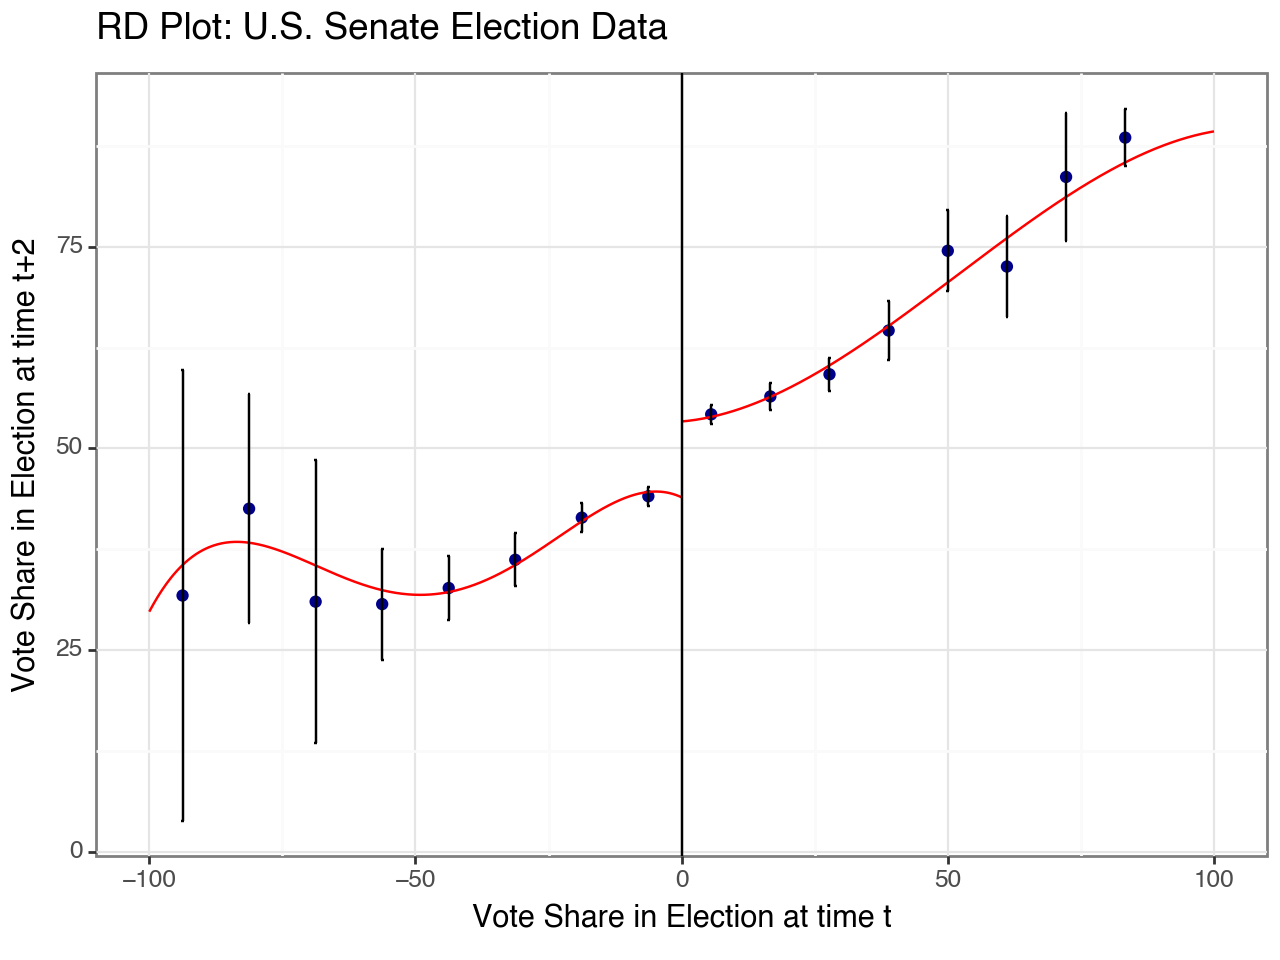


Call: rdplot
Number of Observations:                  1297
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations           595        702
Number of Effective Obs          595        702
Bandwith poly. fit (h)         100.0      100.0
Number of bins scale               1          1
Bins Selected                      8          9
Average Bin Length              12.5     11.111
Median Bin Length               12.5     11.111
IMSE-optimal bins                8.0        9.0
Mimicking Variance bins         15.0       35.0

Relative to IMSE-optimal:
Implied scale                    1.0        1.0
WIMSE variance weight            0.5        0.5
WIMSE bias weight                0.5        0.5


In [4]:
voting_data = pd.read_csv("https://raw.githubusercontent.com/rdpackages/rdrobust/master/Python/rdrobust_senate.csv")

margin = voting_data.margin
vote = voting_data.vote

rdplot(y=vote, x=margin, binselect="es", ci=95, 
       ,
         title="RD Plot: U.S. Senate Election Data", 
         y_label="Vote Share in Election at time t+2",
         x_label="Vote Share in Election at time t")

In [6]:
res_rdd = rdrobust(y=vote, x=margin, all=True)

In [7]:
print(res_rdd)


Call: rdrobust
Number of Observations:                  1297
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           595        702
Number of Unique Obs.            595        665
Number of Effective Obs.         360        323
Bandwidth Estimation          17.754     17.754
Bandwidth Bias                28.028     28.028
rho (h/b)                      0.633      0.633

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       7.414    1.459    5.083   3.722e-07    [4.555, 10.273]
Bias-Corrected     7.507    1.459    5.146   2.661e-07    [4.647, 10.366]
Robust             7.507    1

In [85]:
res_rdd.Estimate

,tau.us,tau.bc,se.us,se.rb
Estimate,7.414131,7.506502,1.458716,1.741258
